In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import openturns as ot

import otagrum as otagr

from utils import learn,timer


# generate results for database (with size `sizes`) and for different correlations

In [2]:
#quick version
sizes=[1000,2000,3000,5000]
nbr=40
maxcorr=nbr//2

#long version
sizes=[1000,2000,3000,5000,10000,15000,20000,35000,50000]
nbr=40
maxcorr=nbr

correlations=[i/nbr for i in range(0,maxcorr)]
conds=ot.Indices()

def getBiNormal(size,correl):
  R=ot.CorrelationMatrix(2)
  R[(0,1)]=correl
    
  mean=ot.Point(2, 2.0)
  sigma=ot.Point(2, 3.0)
  distribution=ot.Normal(mean, sigma, R)

  return distribution.getSample(size)

resttest={}
respvalue={}
restime=[]
for size in sizes:
    resttest[size]=list()
    respvalue[size]=list()
    with timer("Size[{}]".format(size)) as t:
        for corr in correlations:
            (ttest,pvalue,isindep)=otagr.ContinuousTTest(getBiNormal(size,corr)).isIndep(0,1,conds)
            resttest[size].append(ttest)
            respvalue[size].append(pvalue)
    restime.append(t.getDuration()/len(correlations))

+ Size[1000] done in 00.340s
+ Size[2000] done in 00.940s
+ Size[3000] done in 01.905s
+ Size[5000] done in 04.991s
+ Size[10000] done in 18.908s
+ Size[15000] done in 42.561s
+ Size[20000] done in 01:13.753s
+ Size[35000] done in 03:43.350s
+ Size[50000] done in 07:35.442s


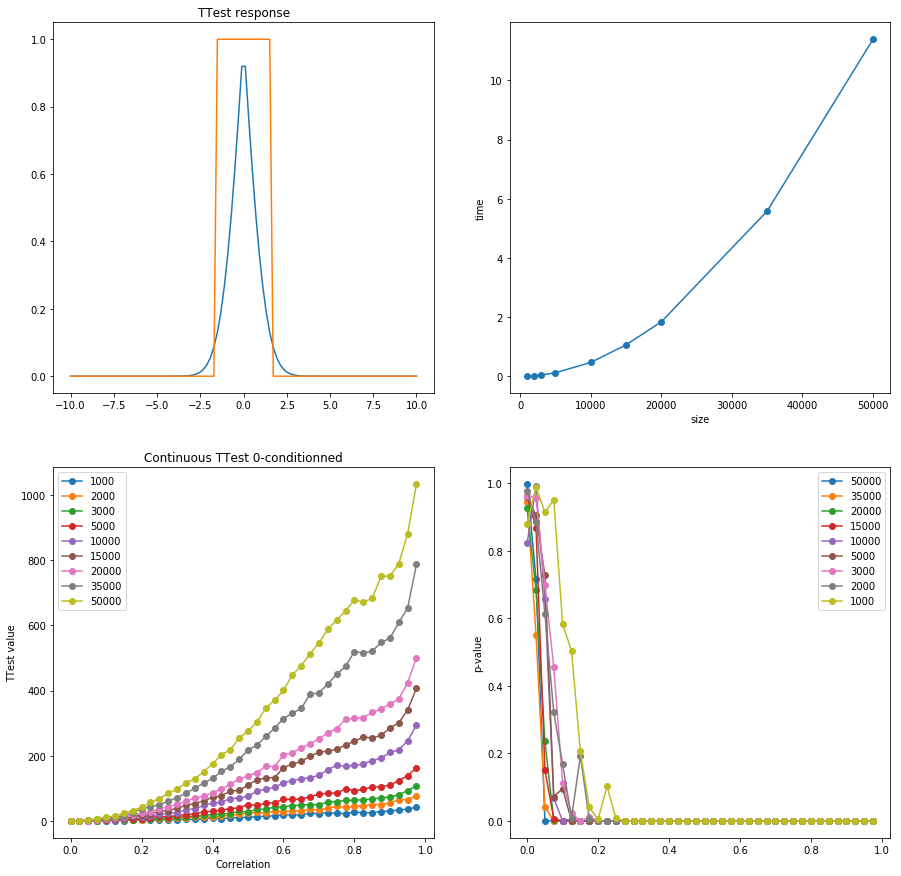

In [3]:
plt.figure(figsize=(15,15))
plt.subplot(2,2, 3)
for size in sizes:
    plt.plot(correlations,resttest[size], 'o-',label=str(size))
plt.title('Continuous TTest 0-conditionned')
plt.ylabel('TTest value')
plt.xlabel('Correlation')
plt.legend()

plt.subplot(2 ,2, 4)
for size in sizes[::-1]:
    plt.plot(correlations,respvalue[size], 'o-',label=str(size))
plt.ylabel('p-value')
plt.legend()

plt.subplot(2 ,2, 2)
plt.plot(sizes,restime, 'o-')
plt.ylabel('time')
plt.xlabel('size')


plt.subplot(2 ,2, 1)
x=np.linspace(-10,10,100)
plt.plot(x,[otagr.ContinuousTTest.isIndepFromTest(x,0.1)[1:3] for x in x])
plt.title("TTest response")
plt.savefig("ContinuousTest_by_correlation.pdf")
plt.show()        

In [4]:
from time import time 
import math

def updateStats(x,v):
    x['mean']+=v
    x['stdev']+=v*v
    if x['min']>v:
        x['min']=v
    if x['max']<v:
        x['max']=v

conds=ot.Indices()

def finalizeStats(x,epoch):
    x['mean']/=epoch
    x['stdev']=math.sqrt(x['stdev']/epoch-x['mean']*x['mean'])

def statsFor(nbrVar,nbr,epoch=20):
    print("=====",nbr,"=====")

    stats_v={'mean':0.0,'stdev':0.0,'min':1000000.0,'max':0.0}
    stats_t={'mean':0.0,'stdev':0.0,'min':1000000.0,'max':0.0}

    for i in range(epoch):
        data=ot.IndependentCopula(5).getSample(nbr)
        t0 = time()
        minval=100
        for y in range(nbrVar):
            for z in range(y+1,nbrVar):
                (ttest,pvalue,isindep)=otagr.ContinuousTTest(data).isIndep(y,z,conds)
                if pvalue*100<minval:
                    minval=pvalue*100
        t1=time()
        if minval==0:
            break
        else:
            #mean
            updateStats(stats_v,minval)
            updateStats(stats_t,t1-t0)

    finalizeStats(stats_v,epoch)
    finalizeStats(stats_t,epoch)

    #print("v:",stats_v)
    #print("t:",stats_t)
    return stats_v,stats_t

nbrVar=5

# quick version
sampleStart=100
sampleStop=1600 #10000
sampleStep=300


# long version
sampleStart=100
sampleStop=10000
sampleStep=300

x=[]
vy=[]
vy1=[]
vy2=[]
vyerr_min=[]
vyerr_max=[]
ty=[]
tyerr_min=[]
tyerr_max=[]
for nbr in range(sampleStart,sampleStop,sampleStep):
    v,t=statsFor(nbrVar,nbr)
    if v['mean']==0:
        #print("Valeur nulle")
        continue
    x.append(nbr)
    vy.append(v['mean'])
    vyerr_min.append(v['mean']-v['min'])
    vyerr_max.append(v['max']-v['mean'])
    vy1.append(v['mean']-2*v['stdev'])
    vy2.append(v['mean']+2*v['stdev'])
    ty.append(t['mean'])
    tyerr_min.append(t['mean']-t['min'])
    tyerr_max.append(t['max']-t['mean'])
 

===== 100 =====
===== 400 =====
===== 700 =====
===== 1000 =====
===== 1300 =====
===== 1600 =====
===== 1900 =====
===== 2200 =====
===== 2500 =====
===== 2800 =====
===== 3100 =====
===== 3400 =====
===== 3700 =====
===== 4000 =====
===== 4300 =====
===== 4600 =====
===== 4900 =====
===== 5200 =====
===== 5500 =====
===== 5800 =====
===== 6100 =====
===== 6400 =====
===== 6700 =====
===== 7000 =====
===== 7300 =====
===== 7600 =====
===== 7900 =====
===== 8200 =====
===== 8500 =====
===== 8800 =====
===== 9100 =====
===== 9400 =====
===== 9700 =====


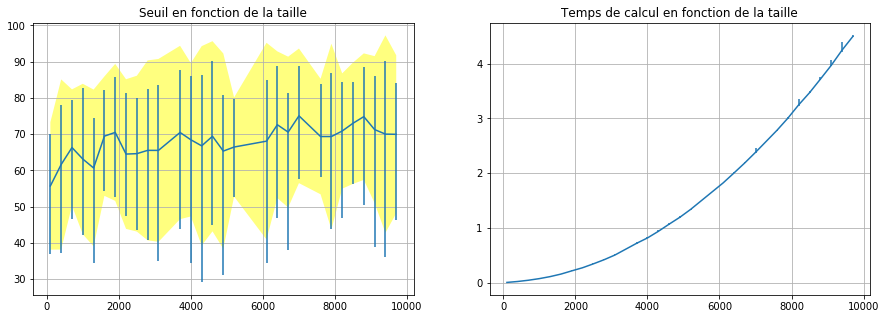

In [6]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True,figsize=(15,5))
ax0.fill_between(x,vy1,vy2,facecolor='yellow',alpha=0.5)
ax0.errorbar(x, vy, yerr= [vyerr_min,vyerr_max])
ax0.set_title("Seuil en fonction de la taille")
ax0.grid()
ax1.errorbar(x, ty, yerr= [tyerr_min,tyerr_max])
ax1.set_title("Temps de calcul en fonction de la taille")
ax1.grid()
plt.show()
fig.savefig('seuilIndep.pdf', dpi=100)